In [1]:
from data_prep import *
from PositionModel import *
from PlayerModel import *
from commons import *
import shap
from sklearn.ensemble import RandomForestRegressor

In [2]:
features = ['goals_scored_avg5', 'xG_avg5', 'assists_fpl_avg5',
       'bonus_avg5', 'bps_avg5', 'clean_sheets_avg5', 'goals_conceded_avg5',
       'shots_avg5', 'xGBuildup_avg5', 'xGChain_avg5', 'yellow_cards_avg5',
       'red_cards_avg5', 'was_home', 'rating_diff']
rolling_columns = ['goals_scored', 'xG', 'assists_fpl', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'shots', 'xGBuildup', 'xGChain', 'yellow_cards', 'red_cards']
to_predict = 'total_points'

In [3]:
# loading dataset
# previous_games = merged_understat_and_fpl(rolling_columns, True)
previous_games = load_dataset()

In [4]:
# splitting data
X_train = previous_games[features]
y_train = previous_games[to_predict]

In [5]:
for f in X_train.iloc[0]:
    print(type(f))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [6]:
# general model fitting
general_model = RandomForestRegressor(random_state=42)
general_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [7]:
# getting next gameweek
next_gameweek = get_next_gameweek(previous_games, NEXT_GAMEWEEK, rolling_columns)

In [8]:
# removing NaNs
next_gameweek = next_gameweek.dropna(subset = features)

In [9]:
next_gameweek.iloc[0]

Unnamed: 0.1               NaN
Unnamed: 0                 NaN
season                     NaN
name                 Eric Dier
position_fpl               DEF
                      ...     
opp_team               Arsenal
team_rating        1873.337769
opp_team_rating     1872.17749
rating_diff            0.00062
next_gameweek             True
Name: 80, Length: 77, dtype: object

In [10]:
# predicting
pred_points = general_model.predict(next_gameweek[features])

In [11]:
pred_points

array([ 5.65,  3.24,  2.74, 11.37,  5.26,  7.44,  7.89,  6.96,  4.9 ,
        4.43,  7.37,  1.94,  1.01,  1.96,  1.95,  3.61,  2.02,  5.16,
        3.82,  3.6 ,  2.04,  1.4 ,  3.07,  1.84,  3.59,  2.99,  3.37,
        6.32,  3.98,  1.36,  3.81,  5.  ,  2.84,  2.34,  2.39,  4.24,
        0.59,  6.87,  3.3 ,  1.28,  1.24,  2.89,  3.2 ,  3.28,  7.14,
        2.14,  4.44,  1.94,  1.15,  5.7 ,  1.51,  8.2 ,  8.15,  3.64,
        0.97,  4.86,  2.12,  2.4 ,  3.88, 10.7 ,  3.07,  2.71,  2.55,
        2.4 ,  3.13,  6.67])

In [12]:
predictions = next_gameweek
predictions.insert(1, 'pred_points', pred_points)
predictions = predictions.sort_values(by = 'pred_points', ascending = False)

In [13]:
predictions[['name', 'was_home', 'opp_team_rating', 'pred_points']].head(20)

,name,was_home,opp_team_rating,pred_points
84,Harry Kane,0,1872.177490,11.37
51,James Maddison,1,1589.250000,10.70
72,Phil Foden,1,1806.040283,8.20
64,Kevin De Bruyne,1,1806.040283,8.15
81,Pierre-Emile Højbjerg,0,1872.177490,7.89
82,Rodrigo Bentancur,0,1872.177490,7.44
41,Christian Nørgaard,0,1638.479126,7.37
30,Reece James,0,1749.146973,7.14
79,Dejan Kulusevski,0,1872.177490,6.96
35,Yoane Wissa,0,1638.479126,6.87


In [14]:
# shap for predictions
explainer_pred = shap.Explainer(general_model, X_train)
shap_values_pred = explainer_pred(next_gameweek[features], check_additivity=False)

In [15]:
def get_shap_index_by_name(df, name):
    index = 0
    for i, r in df.iterrows():
        if r['name'] == name:
            return index
        index += 1
    return None

NAME: Rodrigo Bentancur
INDEX: 5


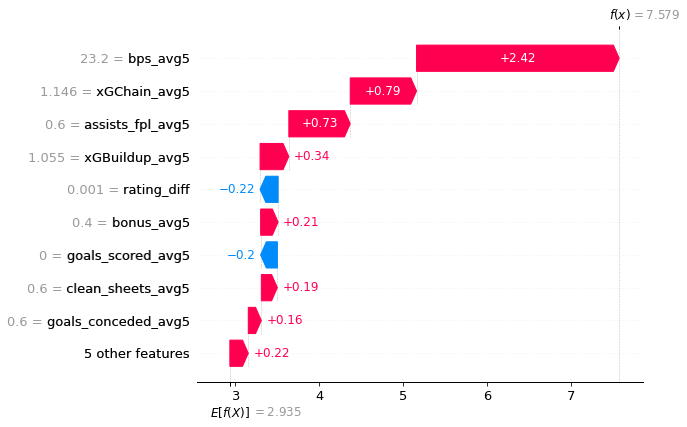

In [16]:
name = 'Rodrigo Bentancur'
index = get_shap_index_by_name(next_gameweek, name)
print('NAME:', name)
print('INDEX:', index)
shap.plots.waterfall(shap_values_pred[index])

In [17]:
# shap for previous games
explainer = shap.Explainer(general_model, X_train)
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 5573/5599 [02:47<00:00]        

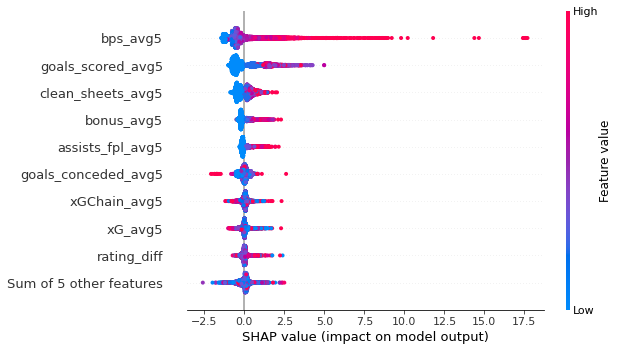

In [18]:
# feature influence
shap.plots.beeswarm(shap_values)

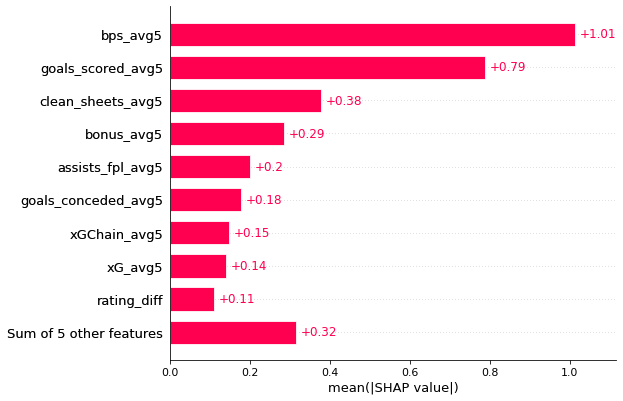

In [19]:
# feature importance
shap.plots.bar(shap_values)